# Data Mining Cup Task - 2019

### For Predictive Analytics, all homework assignments are building on constructing a solution for the 2019 Data Mining Cup task. This folder is for combining all homework code to construct a final solution.

In [1]:
## Importing all necessary libraries:

import boto3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import precision_recall_cutoff as prc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report

In [2]:
## Reading in the data sets

## Defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448-bucket-callaghan'
bucket = s3.Bucket(bucket_name)

file_key = 'train.csv'
file_key2 = 'test.csv'

bucket_object = bucket.Object(file_key)
bucket_object2 = bucket.Object(file_key2)

file_object = bucket_object.get()
file_object2 = bucket_object2.get()

file_content_stream = file_object.get('Body')
file_content_stream2 = file_object2.get('Body')

train = pd.read_csv(file_content_stream, sep = '|')
test = pd.read_csv(file_content_stream2, sep = '|')

train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


## Initial Exploration

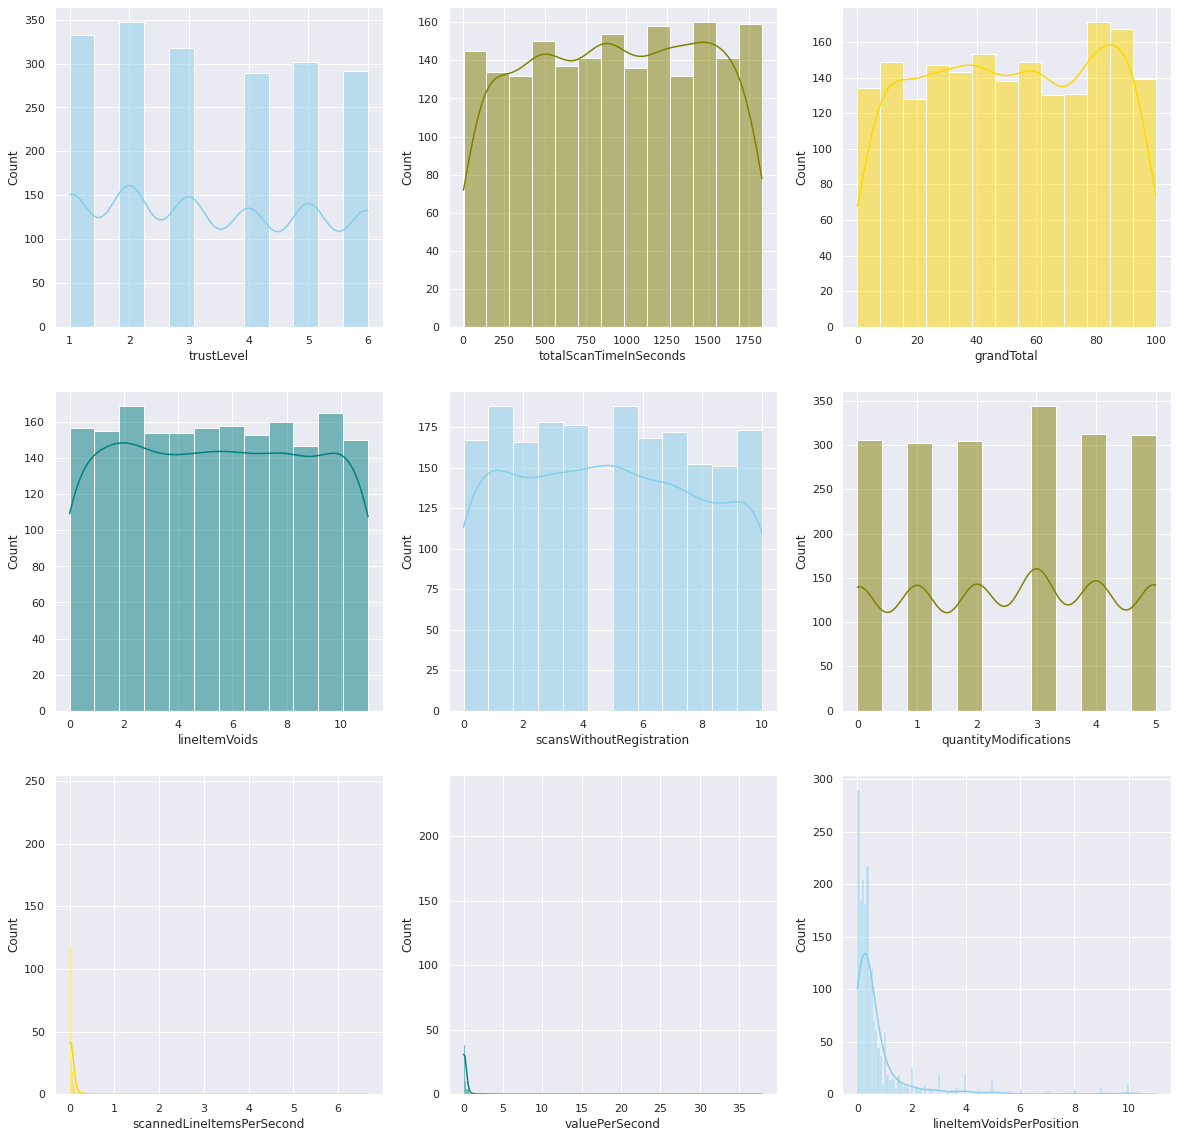

In [3]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(3, 3, figsize=(20, 20))

sns.histplot(data=train, x="trustLevel", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=train, x="totalScanTimeInSeconds", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=train, x="grandTotal", kde=True, color="gold", ax=axs[0, 2])
sns.histplot(data=train, x="lineItemVoids", kde=True, color="teal", ax=axs[1, 0])
sns.histplot(data=train, x="scansWithoutRegistration", kde=True, color="skyblue", ax=axs[1, 1])
sns.histplot(data=train, x="quantityModifications", kde=True, color="olive", ax=axs[1, 2])
sns.histplot(data=train, x="scannedLineItemsPerSecond", kde=True, color="gold", ax=axs[2, 0])
sns.histplot(data=train, x="valuePerSecond", kde=True, color="teal", ax=axs[2, 1])
sns.histplot(data=train, x="lineItemVoidsPerPosition", kde=True, color="skyblue", ax=axs[2, 2])

plt.show()

## Data Cleaning

In [4]:
## Scaling input variables to 0-1

scaler = MinMaxScaler(feature_range = (0.0000001,1))

train[['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids', 
       'scansWithoutRegistration', 'quantityModifications', 'scannedLineItemsPerSecond', 
       'valuePerSecond', 'lineItemVoidsPerPosition']] = scaler.fit_transform(train[['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 
                                                                                    'lineItemVoids', 'scansWithoutRegistration', 'quantityModifications', 
                                                                                    'scannedLineItemsPerSecond', 'valuePerSecond', 
                                                                                    'lineItemVoidsPerPosition']])

test[['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids', 
       'scansWithoutRegistration', 'quantityModifications', 'scannedLineItemsPerSecond', 
       'valuePerSecond', 'lineItemVoidsPerPosition']] = scaler.fit_transform(test[['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 
                                                                                    'lineItemVoids', 'scansWithoutRegistration', 'quantityModifications', 
                                                                                    'scannedLineItemsPerSecond', 'valuePerSecond', 
                                                                                    'lineItemVoidsPerPosition']])

In [5]:
## Performing log transformation on: scannedLineItemsPerSecond, valuePerSecond, and lineItemVoidsPerPosition

train['scannedLineItemsPerSecond'] = np.log(train['scannedLineItemsPerSecond'])
test['scannedLineItemsPerSecond'] = np.log(test['scannedLineItemsPerSecond'])

train['valuePerSecond'] = np.log(train['valuePerSecond'])
test['valuePerSecond'] = np.log(test['valuePerSecond'])

train['lineItemVoidsPerPosition'] = np.log(train['lineItemVoidsPerPosition'])
test['lineItemVoidsPerPosition'] = np.log(test['lineItemVoidsPerPosition'])

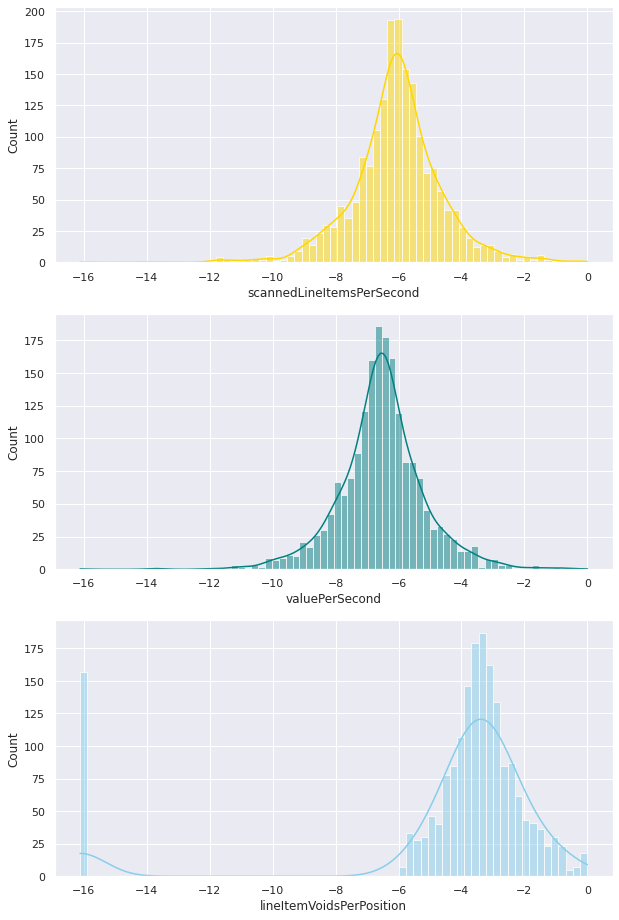

In [6]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(3, 1, figsize=(10, 16))

sns.histplot(data=train, x="scannedLineItemsPerSecond", kde=True, color="gold", ax=axs[0])
sns.histplot(data=train, x="valuePerSecond", kde=True, color="teal", ax=axs[1])
sns.histplot(data=train, x="lineItemVoidsPerPosition", kde=True, color="skyblue", ax=axs[2])

plt.show()

## Variable Engineering

[Text(643.8461538461538, 761.04, 'trustLevel <= 0.1\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(343.38461538461536, 543.6, 'lineItemVoidsPerPosition <= -3.175\ngini = 0.396\nsamples = 265\nvalue = [193, 72]'),
 Text(171.69230769230768, 326.15999999999997, 'scannedLineItemsPerSecond <= -6.16\ngini = 0.485\nsamples = 164\nvalue = [96, 68]'),
 Text(85.84615384615384, 108.72000000000003, 'gini = 0.142\nsamples = 39\nvalue = [36, 3]'),
 Text(257.53846153846155, 108.72000000000003, 'gini = 0.499\nsamples = 125\nvalue = [60, 65]'),
 Text(515.0769230769231, 326.15999999999997, 'valuePerSecond <= -9.497\ngini = 0.076\nsamples = 101\nvalue = [97, 4]'),
 Text(429.23076923076917, 108.72000000000003, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(600.9230769230769, 108.72000000000003, 'gini = 0.058\nsamples = 100\nvalue = [97, 3]'),
 Text(944.3076923076923, 543.6, 'trustLevel <= 0.3\ngini = 0.018\nsamples = 1238\nvalue = [1227, 11]'),
 Text(858.4615384615383, 326.15999999999997, '

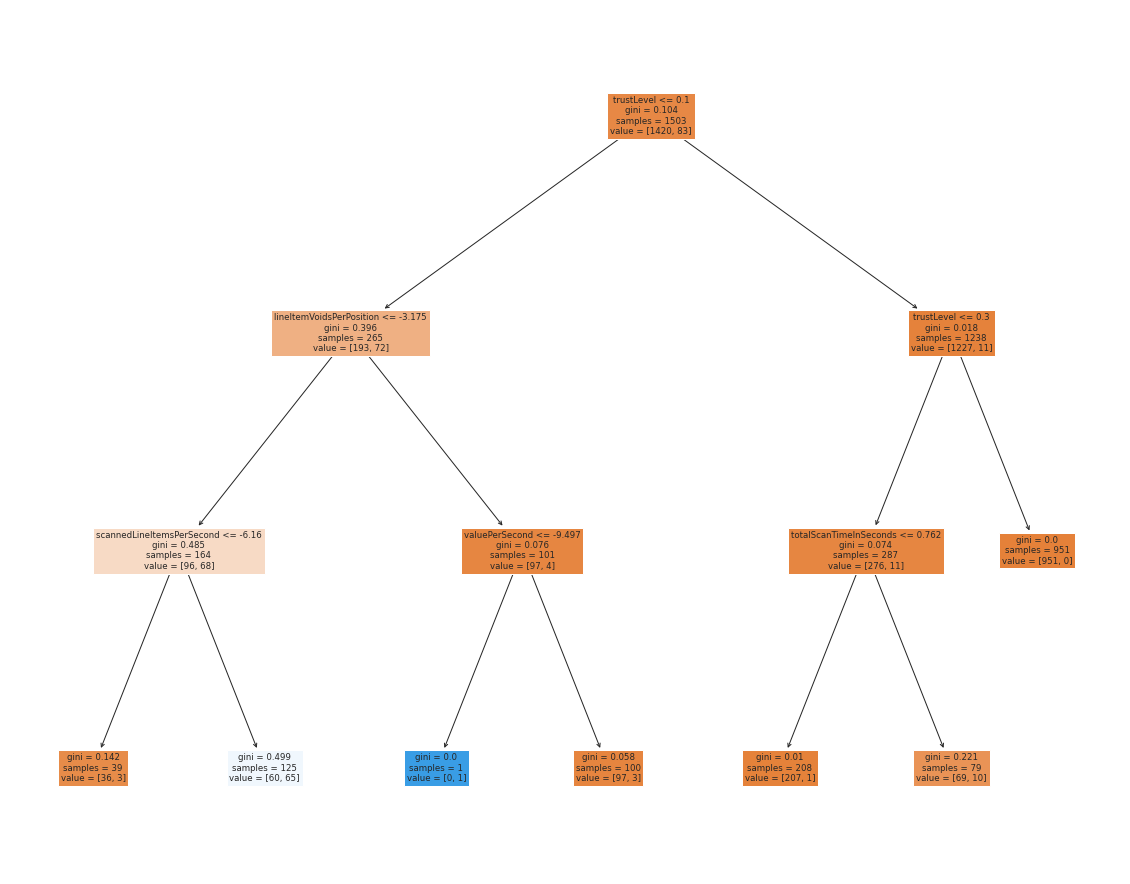

In [7]:
## Creating decision tree to find new feature relationships

## Defining the input and target variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

## Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

## Building a decision tree model with max depth = 3 on the train data-frame
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

## Visualizing the decision tree model and identify any interesting interactions/features
fig = plt.figure(figsize = (20, 16))
plot_tree(tree_md, feature_names = X.columns, filled = True)

In [8]:
train['Interaction_1'] = np.where((train['trustLevel'] <= 0.1) & (train['lineItemVoidsPerPosition'] <= -3.175) & 
                                  (train['lineItemVoids'] <= 0.682), 1, 0)
test['Interaction_1'] = np.where((test['trustLevel'] <= 0.1) & (test['lineItemVoidsPerPosition'] <= -3.175) & 
                                  (test['lineItemVoids'] <= 0.682), 1, 0)


train['Interaction_2'] = np.where((train['trustLevel'] <= 0.1) & (train['lineItemVoidsPerPosition'] > -3.175) & 
                                  (train['valuePerSecond'] <= -9.342), 1, 0)
test['Interaction_2'] = np.where((test['trustLevel'] <= 0.1) & (test['lineItemVoidsPerPosition'] > -3.175) & 
                                  (test['valuePerSecond'] <= -9.342), 1, 0)


train['Interaction_3'] = np.where((train['trustLevel'] > 0.1) & (train['trustLevel'] <= 0.3) & 
                                  (train['totalScanTimeInSeconds'] <= 0.992), 1, 0)
test['Interaction_3'] = np.where((test['trustLevel'] > 0.1) & (test['trustLevel'] <= 0.3) & 
                                  (test['totalScanTimeInSeconds'] <= 0.992), 1, 0)


train['Interaction_4'] = np.where((train['trustLevel'] > 0.1) & (train['trustLevel'] > 0.3), 1, 0)
test['Interaction_4'] = np.where((test['trustLevel'] > 0.1) & (test['trustLevel'] > 0.3), 1, 0)

In [9]:
## Creating a dummy variable with trustLevel

train = pd.concat([train.drop(columns = ['trustLevel']), pd.get_dummies(train['trustLevel'])], axis = 1)
test = pd.concat([test.drop(columns = ['trustLevel']), pd.get_dummies(test['trustLevel'])], axis = 1)

train = train.rename(columns = { 1.0000000000287557e-07: 'trustLevel_1', 0.20000008000000002: 'trustLevel_2', 0.40000006: 'trustLevel_3', 
                                0.6000000400000001: 'trustLevel_4', 0.8000000200000001: 'trustLevel_5', 1: 'trustLevel_6'})
test = test.rename(columns = { 1.0000000000287557e-07: 'trustLevel_1', 0.20000008000000002: 'trustLevel_2', 0.40000006: 'trustLevel_3', 
                                0.6000000400000001: 'trustLevel_4', 0.8000000200000001: 'trustLevel_5', 1: 'trustLevel_6'})

In [11]:
train.shape

(1879, 19)